In [92]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [93]:
# load data
apple_df = pd.read_csv("data/clean/AAPL_feature_engineered.csv")
apple_df.head()

,Date,Close,Volume,Open,High,Low,Daily_Return,5_day_mean_close_price,5_day_mean_volume,Daily_Range,Volatility,Quarter,EMA_Close_5,EMA_Close_20
0,2023-07-21,191.94,0.039229,0.994496,0.982184,0.992009,0.420177,0.0,0.00000,0.285545,0.0,2023Q3,0.990638,0.996143
1,2023-07-20,193.13,0.027310,1.000000,0.990382,0.999128,0.444526,0.0,0.00000,0.304057,0.0,2023Q3,0.992866,0.996786
2,2023-07-19,195.10,0.047551,0.988937,1.000000,1.000000,0.460237,0.0,0.00000,0.430484,0.0,2023Q3,0.998040,0.998432
3,2023-07-18,193.73,0.016450,0.990327,0.978686,0.998678,0.392600,0.0,0.00000,0.141788,0.0,2023Q3,0.998924,0.999182
4,2023-07-17,193.99,0.018546,0.982266,0.978632,0.995273,0.425448,1.0,0.09551,0.188657,0.0,2023Q3,1.000000,1.000000


In [94]:
# Define the features and target variables
target = ['Close']

# Define the features
features = apple_df.drop(['Close', 'Date', 'Quarter'], axis=1).columns.tolist()

# Create arrays for the features and the response variable
X = apple_df[features].values
y = apple_df[target].values


# Apply scaling to the target variable 'y' (Close prices)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)



# Split the dataset into training and test sets: 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, shuffle=False)

In [95]:
# LSTM expects input in the form of [samples, time steps, features] - 3D tensor (3D array) 

# 1 time step (previous day's data) for each sample
time_steps = 1 

print(X_train.shape)
print(X_test.shape)
X_train_lstm = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])

# avoid this error ==> ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
X_train_lstm = X_train_lstm.astype('float32')
X_test_lstm = X_test_lstm.astype('float32')

print(X_train_lstm.shape)
print(X_test_lstm.shape)

(2013, 11)
(504, 11)
(2013, 1, 11)
(504, 1, 11)


In [96]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Initialize the LSTM model
model = Sequential()

# Add the LSTM layer with 50 units and input shape (time_steps, features)
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))

# Add a Dense layer to output the predicted value
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [97]:
# Train the model on the training data
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)


Epoch 1/100
252/252 [==============================] - 2s 3ms/step - loss: 0.5453
Epoch 2/100
252/252 [==============================] - 0s 1ms/step - loss: 1.0600
Epoch 3/100
252/252 [==============================] - 0s 1ms/step - loss: 0.1659
Epoch 4/100
252/252 [==============================] - 0s 2ms/step - loss: 0.0556
Epoch 5/100
252/252 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 6/100
252/252 [==============================] - 0s 1ms/step - loss: 0.0169
Epoch 7/100
252/252 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 8/100
252/252 [==============================] - 0s 1ms/step - loss: 0.0133
Epoch 9/100
252/252 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 10/100
252/252 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 11/100
252/252 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 12/100
252/252 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 13/100


In [98]:
#LSTM Prediction
y_pred_scaled = model.predict(X_test_lstm)

# Inverse scaling the predictions and true values for visualization
y_pred_original = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

16/16 [==============================] - 0s 1ms/step


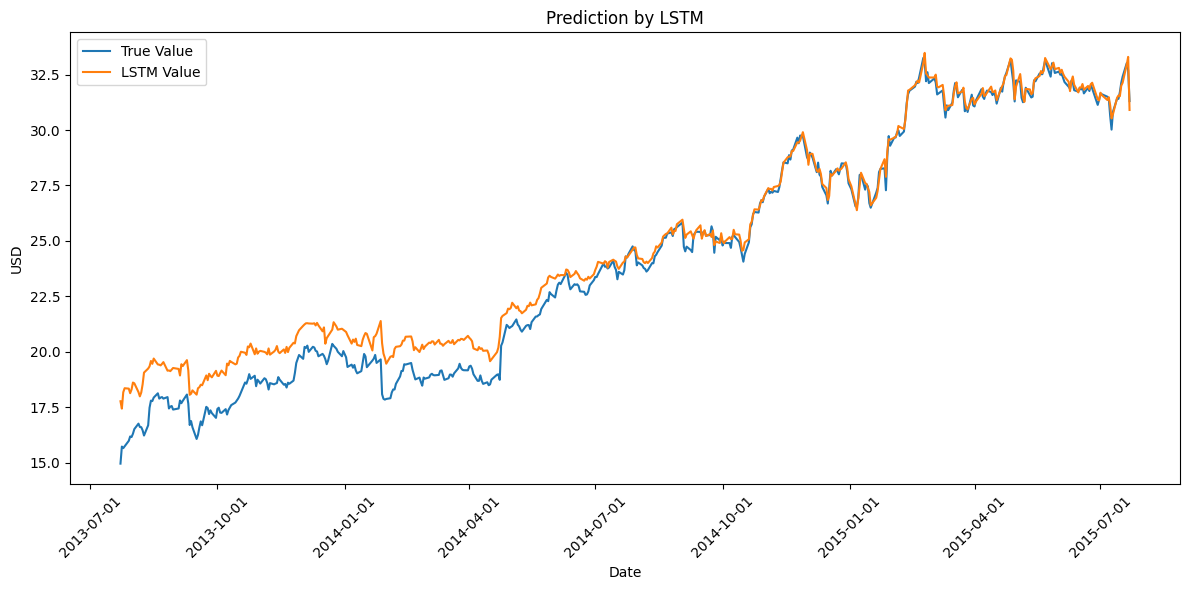

In [101]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# Extract the dates for plotting
dates = pd.to_datetime(apple_df['Date']).iloc[-len(y_test_original):]  # Dates corresponding to the test set

# Plot the results with adjusted intervals on the x-axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, y_test_original, label='True Value')
ax.plot(dates, y_pred_original, label='LSTM Value')
ax.set_title('Prediction by LSTM')
ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax.legend()

# Format the x-axis date intervals to show approximately 20 date labels
interval = len(dates) // 20
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()